## Loading data

In [27]:
import sqlite3
import pandas as pd
import numpy as np
import json
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.utils import resample
from sklearn import svm

In [2]:
conn = sqlite3.connect('sqlite.db')
df_exec = pd.read_sql_query("SELECT * FROM 'exec';", conn)

In [3]:
display(df_exec.head())

,ts,exe,pid,ppid,path,docker,depth,rates
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}"
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}"
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}"
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}"
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}"


In [4]:
df_exec['rates1'] = np.nan
df_exec['rates5'] = np.nan
for it in enumerate(df_exec.rates.values):
    Dic = json.loads((it[1]))
    df_exec.set_value(it[0], 'rates1', Dic["1"])
    df_exec.set_value(it[0], 'rates5', Dic["5"])
    
df_exec = df_exec.sort_values('ts').reset_index(drop=True)    
   

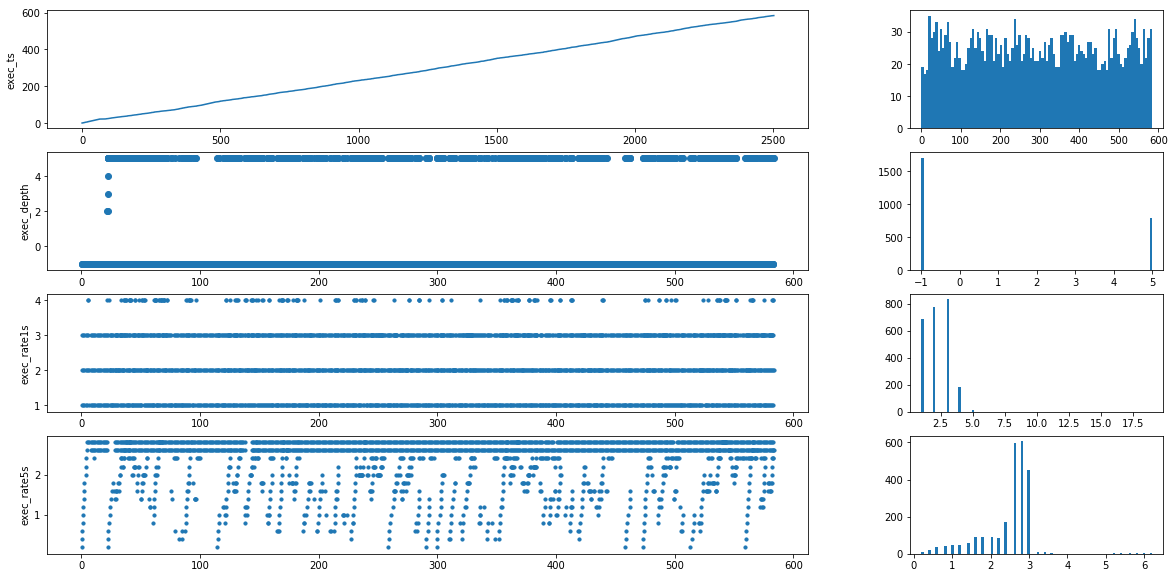

In [21]:

f, subplt = plt.subplots(4,2,gridspec_kw = {'width_ratios':[3, 1]})
subplt[0, 0].plot(df_exec['ts'])
subplt[0, 0].set_ylabel('exec_ts') 
subplt[0, 1].hist(df_exec['ts'],bins = 100)

subplt[1, 0].scatter(df_exec['ts'],df_exec['depth'])
subplt[1, 1].hist(df_exec['depth'],bins = 100)
subplt[1, 0].set_ylabel('exec_depth') 

#subplt[2, 0].scatter(df_exec['ts'],df_exec['rates1'],linewidth=0.1)
subplt[2, 0].scatter(df_exec[df_exec['rates1']<5]['ts'],df_exec[df_exec['rates1']<5]['rates1'],s=10)
subplt[2, 1].hist(df_exec['rates1'],bins = 100)
subplt[2, 0].set_ylabel('exec_rate1s') 


#subplt[3, 0].scatter(df_exec['ts'],df_exec['rates5'])
subplt[3, 0].scatter(df_exec[df_exec['rates5']<3]['ts'],df_exec[df_exec['rates5']<3]['rates5'],s=10)
subplt[3, 1].hist(df_exec['rates5'],bins = 100)
subplt[3, 0].set_ylabel('exec_rate5s') 

f.set_figwidth(20)
f.set_figheight(10)
#tm = df_exec[['ts','rates1']].set_index('ts')
#tm.plot(figsize=(20,7))
plt.show()

In [6]:
df_tcplife = pd.read_sql_query("SELECT * FROM 'tcplife';", conn)
conn.close()

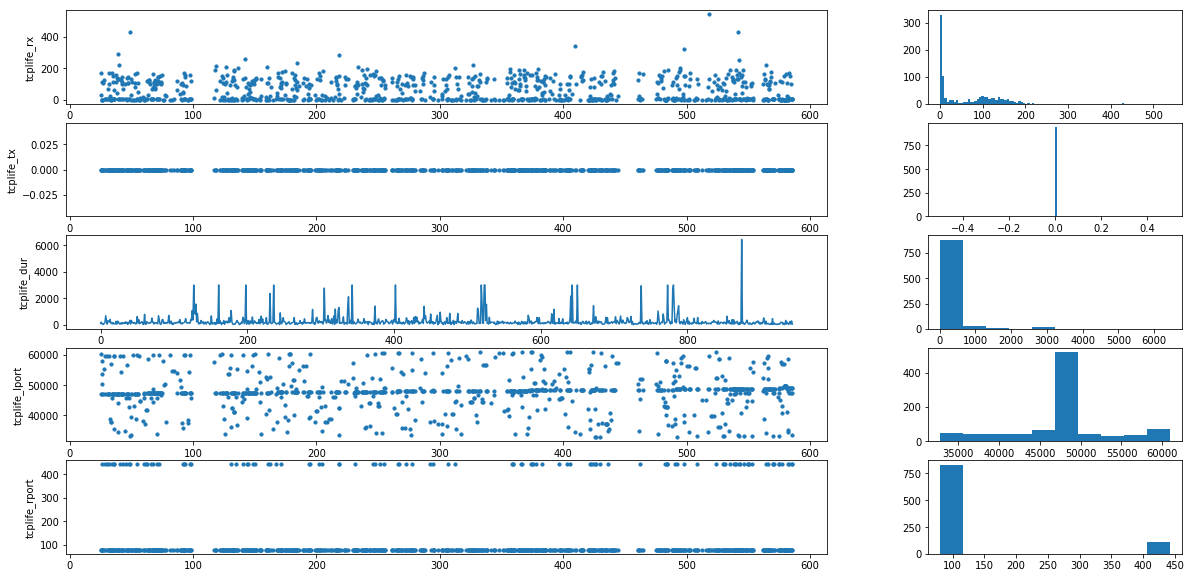

In [22]:

f, subplt = plt.subplots(5,2,gridspec_kw = {'width_ratios':[3, 1]})

subplt[0, 0].scatter(df_tcplife['ts'],df_tcplife['rx'],s=10)
subplt[0, 1].hist(df_tcplife['rx'],bins = 100)
subplt[0, 0].set_ylabel('tcplife_rx') 

subplt[1, 0].scatter(df_tcplife['ts'],df_tcplife['tx'],s=10)
subplt[1, 1].hist(df_tcplife['tx'],bins = 100)
subplt[1, 0].set_ylabel('tcplife_tx') 

subplt[2, 0].plot(df_tcplife['dur'])
subplt[2, 0].set_ylabel('tcplife_dur') 
subplt[2, 1].hist(df_tcplife['dur'])


subplt[3, 0].scatter(df_tcplife['ts'],df_tcplife['lport'],s=10)
subplt[3, 1].hist(pd.to_numeric(df_tcplife['lport']))
subplt[3, 0].set_ylabel('tcplife_lport') 

subplt[4, 0].scatter(df_tcplife['ts'],df_tcplife['rport'],s=10)
subplt[4, 1].hist(pd.to_numeric(df_tcplife['rport']))
subplt[4, 0].set_ylabel('tcplife_rport') 

f.set_figwidth(20)
f.set_figheight(10)
plt.show()


In [24]:
df_tcplife.describe()

,ts,pid,rx,tx,dur,prediction,predquality
count,944.000000,944.000000,944.000000,944.0,944.000000,944.000000,944.000000
mean,307.715209,29928.452331,61.332627,0.0,261.219121,-15.492141,0.875000
std,171.971029,751.111665,69.228605,0.0,479.331879,23.434887,0.330894
min,25.147065,28668.000000,0.000000,0.0,5.040000,-569.245187,0.000000
25%,157.886505,29267.750000,4.000000,0.0,85.512500,-13.940197,1.000000
50%,307.397860,29935.500000,26.000000,0.0,144.650000,-11.497844,1.000000
75%,462.115531,30601.000000,115.000000,0.0,226.797500,-10.481379,1.000000
max,585.672974,31149.000000,540.000000,0.0,6454.020000,8.375431,1.000000


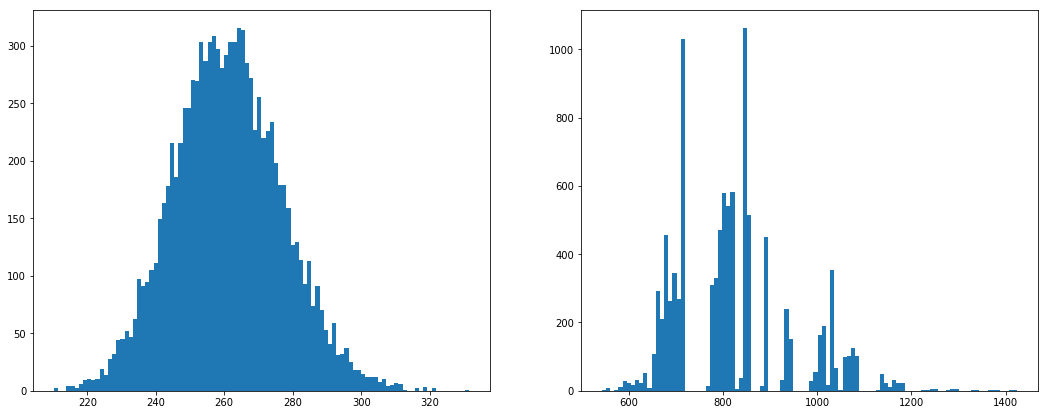

In [28]:
np.percentile(np.array(df_tcplife.dur),99)

#use bootstrapping to approximate the real distribution of "dur"
bootstrapping_dist = np.zeros(10000)
tile_dist = np.zeros(10000)
for i in range(10000):
    X = resample(np.array(df_tcplife.dur), replace=True)
    bootstrapping_dist[i] = np.mean(X)
    tile_dist[i] = np.percentile(X,95)
    

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,7)) 
ax1.hist(bootstrapping_dist,bins=100)
#ax1.title('bootstrapping of mean')
ax2.hist(tile_dist,bins=100)
#ax2.title('bootstrapping of 99-percentile')
plt.show()

In [31]:
#get the indexes of outliers
thres = np.percentile(tile_dist,95)
df_outliers = df_tcplife.loc[df_tcplife['dur']>thres]

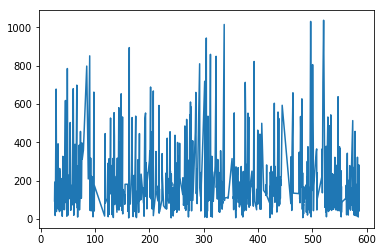

In [32]:
df_tcplife.loc[(df_tcplife['dur']<thres)].shape
plt.plot(df_tcplife.loc[(df_tcplife['dur']<thres)].ts,df_tcplife.loc[(df_tcplife['dur']<thres)].dur)
plt.show()